In [1]:
import sys, os
import pathlib
import time
import importlib
import joblib
import pickle


import numpy as np
from scipy.linalg import null_space


import matplotlib.pyplot as plt

import cv2

In [2]:
%load_ext autoreload
%autoreload 2

if not os.path.abspath("../") in sys.path:
    sys.path.append(os.path.abspath("../"))
    sys.path.append(os.path.abspath("../src-Copy_1"))

from src_Copy_1 import normalization
from src_Copy_1 import Camera, metashape_Camera
from src_Copy_1 import camera_correspondence, FF_mat, epipole_angle, pair_and_key_gen_one_label, coll_dict_gen_one_label, pair_pt_gen_one_label
from src_Copy_1 import coordinate_dict_gen_one_label
from src_Copy_1 import TDlines_gen_one_label, reprojection_gen_one_label, gen_support_one_label
from src_Copy_1 import all_D, frag_list_fraged, all_sep

## camera.py

In [3]:
cam_list = [Camera(i) for i in range(48)]
for i in range(len(cam_list)):
    cam_list[i].img_load("../simlation_data/images/no_hole_leaf_image")
    cam_list[i].contour_extraction()
    cam_list[i].para_load("../simlation_data/view_mats/view_mat/{}.csv".format(str(i)))
    cam_list[i].get_contour_img()
    
cam_pairs = camera_correspondence(cam_list,angle_upper=40 / 180 * np.pi)
print(len(cam_pairs))

152


## epipolar.py

In [4]:
# エピポール取得
epipole_dict = {i:[] for i in range(len(cam_list))}
cam_pairs_F = {}
for i in cam_pairs:
    epipole1, epipole2, F = FF_mat(cam_list[i[0]].A, cam_list[i[1]].A, cam_list[i[0]].Rt, cam_list[i[1]].Rt)
    epipole_dict[i[0]].append(normalization(epipole1))
    epipole_dict[i[1]].append(normalization(epipole2))
    cam_pairs_F[i] = F

## fragment.py

In [5]:
# フラグメントのリストを作る
for i in range(len(cam_list)):
    im_del_list = all_D(epipole_angle(i, epipole_dict, cam_list=cam_list))# im_del_list[color][contour][del_idx]
    newCon = all_sep(cam_list[i].contour_list, im_del_list)# newCon[color][fragment][coordination]
    cam_list[i].frag_list = frag_list_fraged(newCon)

del epipole_dict

C:\home\study\git_test\curve_sketch\src_Copy_1\epipolar.py:87: RuntimeWarning: divide by zero encountered in double_scalars
  tilt = (y - epi_y) / (x - epi_x)


## epipolar.py

In [12]:
LABEL_NUM = 0
label_num = LABEL_NUM

In [13]:
_ = joblib.Parallel(n_jobs=-1, verbose=0)(joblib.delayed(pair_and_key_gen_one_label)(
    label_num, i, cam_list, cam_pairs_F) for i in cam_pairs_F)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 145 out of 152 | elapsed:   33.1s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:   34.6s finished


In [14]:
temp_path = pathlib.Path("temp/")
tags_path = list(temp_path.glob("*.pair_list"))

tags = []
for tag_path in tags_path:
    tag_sp = tag_path.stem.split("_")
    tag_arr = ((int(tag_sp[0]), int(tag_sp[1])), tag_sp[2])
    tags.append(tag_arr)

In [15]:
_ = joblib.Parallel(n_jobs=-1, verbose=0)(joblib.delayed(coll_dict_gen_one_label)(
    label_num, i, cam_list, cam_pairs_F) for i in tags)

_ = joblib.Parallel(n_jobs=-1, verbose=0)(joblib.delayed(pair_pt_gen_one_label)(i) for i in tags)

## curve_based_reconstruction

In [16]:
_ = joblib.Parallel(n_jobs=-1, verbose=0)(joblib.delayed(coordinate_dict_gen_one_label)(
    label_num, i, cam_list) for i in tags)

In [17]:
_ = joblib.Parallel(n_jobs=-1,verbose=0)(joblib.delayed(TDlines_gen_one_label)(
    tag, cam_list=cam_list, cam_pairs_F=cam_pairs_F) for tag in tags)

In [18]:
_ = joblib.Parallel(n_jobs=-1,verbose=0)(joblib.delayed(reprojection_gen_one_label)(tag, cam_list=cam_list) for tag in tags)

In [19]:
_ = joblib.Parallel(n_jobs=-1,verbose=0)(joblib.delayed(gen_support_one_label)(label_num, tag, cam_list, image_shape=(1080, 1920)) for tag in tags)

In [20]:
sup_th = 20# サポート数
curve_fragment = []
for tag in tags:
    if tag[1] == "R":
        continue
    
    with open(r"temp/{0}_{1}_{2}.TDlines".format(tag[0][0],tag[0][1],tag[1]), 'rb') as f:
        lines_list = pickle.load(f)
    #lines_list = TDlines[tag]
        
    with open(r"temp/{0}_{1}_{2}.support_dict".format(tag[0][0],tag[0][1],tag[1]), 'rb') as f:
        support_list, support_ac = pickle.load(f)
    #support_list, support_ac = support_dict[tag][0], support_dict[tag][1]
    tag_list = []
    for frag, sup, sup_ac in zip(lines_list, support_list, support_ac):
        if sup > sup_th:
            frag = np.reshape(frag,(-1, 3))
            frag = np.array([i for i,j in zip(frag, sup_ac >sup_th) if j])
            tag_list.append(frag)
    curve_fragment.append(tag_list)

In [21]:
cfs = []
for cols in curve_fragment:
    cfs += cols

In [22]:
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

def plot_graph():
    color_arr = np.array([[255,0,0],[0,255,0],[0,0,255],
                             [255,255,0],[255,0,255],[0,255,255],
                             [127,127,127],[127,0,127],[0,127,127]],dtype = np.int16)
    j = 0
    for frag in cfs:
        if frag.size < 10:
            continue
        j+=1
        if j % 100 != 0:
            continue
            
        x = frag[:,0]
        y = frag[:,1]
        z = frag[:,2]
        data = [x,y,z]
        try:
            tck, u= interpolate.splprep(data, k=3)
        except ValueError:
            pass
        except TypeError:
            pass
        except UnboundLocalError:
            pass
        new = interpolate.splev(u, tck, der=0)
        
        ax.plot(new[0], new[2], new[1],"-",color="red")
            
        


<IPython.core.display.Javascript object>


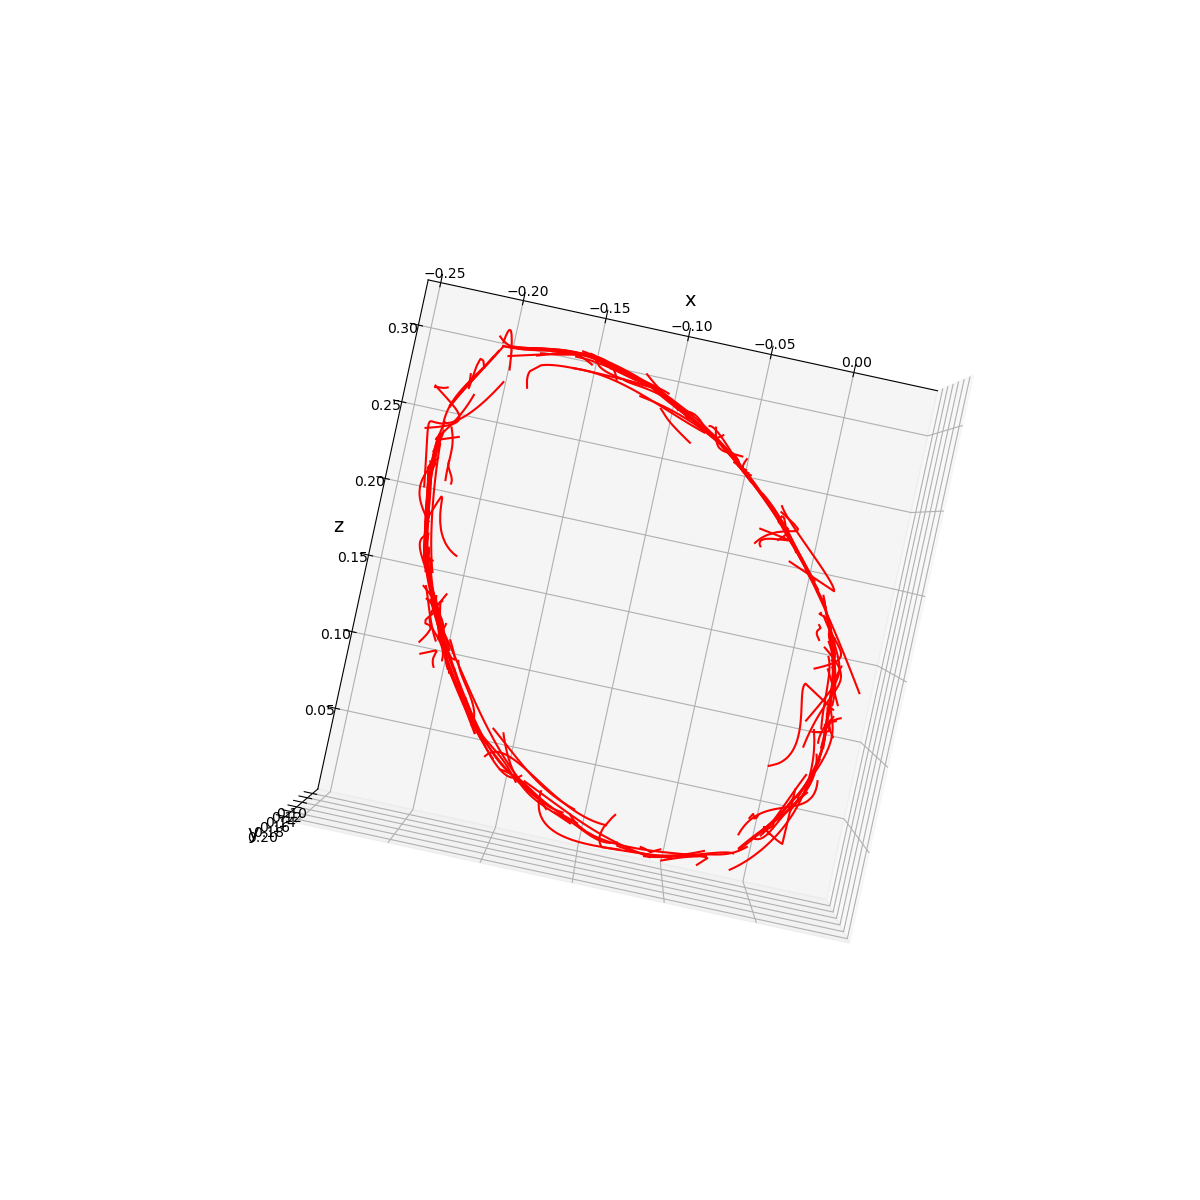

In [23]:
%matplotlib notebook
fig = plt.figure(figsize = (12, 12))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')

# 軸ラベルを設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("z", size = 14)
ax.set_zlabel("y", size = 14)
ax.set_box_aspect((1,1,1))

plot_graph()